In [4]:
import pandas as pd

customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

transactions_enriched_df = transactions_df.merge(products_df, on='ProductID', how='left')
full_data = transactions_enriched_df.merge(customers_df, on='CustomerID', how='left')

category_summary = (
    full_data.groupby(["CustomerID", "Category"])["Quantity"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

spending_summary = (
    full_data.groupby("CustomerID").agg(
        total_spent=("TotalValue", "sum"),
        total_transactions=("TransactionID", "nunique")
    ).reset_index()
)

region_summary = customers_df[["CustomerID", "Region"]]

customer_features = (
    category_summary.merge(spending_summary, on="CustomerID", how="left")
    .merge(region_summary, on="CustomerID", how="left")
)

customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

customer_features.to_csv('CombinedFeatures.csv', index=False)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

customer_features = pd.read_csv('CombinedFeatures.csv')

customer_ids = customer_features['CustomerID']
feature_matrix = customer_features.drop(columns=['CustomerID']).values

similarity_matrix = cosine_similarity(feature_matrix)

lookalike_map = {}

for idx, customer_id in enumerate(customer_ids):
    scores = list(enumerate(similarity_matrix[idx]))
    top_similar = sorted(scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalike_map[customer_id] = [(customer_ids[i], round(score, 4)) for i, score in top_similar]

lookalike_map_filtered = {cid: lookalike_map[cid] for cid in customer_ids[:20]}

import csv

with open('Sushrith_Reddy_Lookalike.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['CustomerID', 'Lookalikes'])
    for customer, lookalikes in lookalike_map_filtered.items():
        writer.writerow([customer, lookalikes])

print("Sushrith_Reddy_Lookalike.csv has been created successfully!")

Sushrith_Reddy_Lookalike.csv has been created successfully!


In [8]:
for customer, lookalikes in lookalike_map_filtered.items():
    print(f"Customer {customer}: Top 3 Lookalikes -> {lookalikes}")

Customer C0001: Top 3 Lookalikes -> [('C0045', 1.0), ('C0140', 1.0), ('C0026', 1.0)]
Customer C0002: Top 3 Lookalikes -> [('C0159', 1.0), ('C0144', 1.0), ('C0134', 1.0)]
Customer C0003: Top 3 Lookalikes -> [('C0195', 1.0), ('C0031', 1.0), ('C0162', 1.0)]
Customer C0004: Top 3 Lookalikes -> [('C0075', 1.0), ('C0012', 1.0), ('C0146', 1.0)]
Customer C0005: Top 3 Lookalikes -> [('C0007', 1.0), ('C0127', 1.0), ('C0163', 1.0)]
Customer C0006: Top 3 Lookalikes -> [('C0082', 1.0), ('C0185', 1.0), ('C0135', 1.0)]
Customer C0007: Top 3 Lookalikes -> [('C0163', 1.0), ('C0005', 1.0), ('C0085', 1.0)]
Customer C0008: Top 3 Lookalikes -> [('C0031', 1.0), ('C0106', 1.0), ('C0093', 1.0)]
Customer C0009: Top 3 Lookalikes -> [('C0198', 1.0), ('C0088', 1.0), ('C0098', 1.0)]
Customer C0010: Top 3 Lookalikes -> [('C0077', 1.0), ('C0176', 1.0), ('C0111', 1.0)]
Customer C0011: Top 3 Lookalikes -> [('C0101', 1.0), ('C0021', 1.0), ('C0016', 1.0)]
Customer C0012: Top 3 Lookalikes -> [('C0065', 1.0), ('C0179', 1.

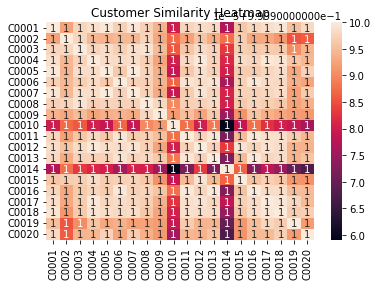

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

similarity_subset = similarity_matrix[:20, :20]
sns.heatmap(similarity_subset, xticklabels=customer_ids[:20], yticklabels=customer_ids[:20], annot=True)
plt.title("Customer Similarity Heatmap")
plt.show()